In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.cluster.hierarchy as sch

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, calinski_harabasz_score
from factor_analyzer import FactorAnalyzer

In [3]:
from data.utils import add_experience, feature_classification, astype_category

In [4]:
# DataFrame 초기 세팅
hr_df = pd.read_csv(Path.cwd() / 'data' / 'HR-Employee-Attrition.csv')
hr_df = (hr_df
         .pipe(add_experience)
         .pipe(feature_classification, return_dataframe=True)
         .pipe(astype_category)
         .set_index('EmployeeNumber')
)
hr_df = (hr_df
         .assign(Attrition=lambda df: df['Attrition'].replace({'Yes':1, 'No':0}))
         .assign(OverTime=lambda df: df['OverTime'].replace({'Yes':1, 'No':0}))
)
hr_df.columns

Index(['MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'Age',
       'Gender', 'MaritalStatus', 'Education', 'EducationField',
       'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
       'Experienced', 'Department', 'BusinessTravel', 'JobLevel', 'JobRole',
       'JobInvolvement', 'OverTime', 'WorkLifeBalance',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'PerformanceRating',
       'RelationshipSatisfaction', 'Attrition'],
      dtype='object')

In [5]:
# 필요 내용 category 변경 확인
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   MonthlyIncome             1470 non-null   int64   
 1   PercentSalaryHike         1470 non-null   int64   
 2   StockOptionLevel          1470 non-null   int64   
 3   Age                       1470 non-null   int64   
 4   Gender                    1470 non-null   category
 5   MaritalStatus             1470 non-null   category
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   category
 8   DistanceFromHome          1470 non-null   int64   
 9   NumCompaniesWorked        1470 non-null   int64   
 10  TotalWorkingYears         1470 non-null   int64   
 11  Experienced               1470 non-null   category
 12  Department                1470 non-null   category
 13  BusinessTravel            1470 non-null   catego

In [6]:
# categorical variables에 대한 one-hot encoding
hr_df_onehot = pd.get_dummies(hr_df, columns=['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction',
                                              'Experienced', 'Gender', 'JobRole', 'MaritalStatus'])
hr_df_onehot

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,5993,11,0,41,1,8,8,2,3,1,...,0,0,0,0,0,1,0,0,0,1
2,5130,23,1,49,8,1,10,2,2,0,...,0,0,0,0,1,0,0,0,1,0
4,2090,15,0,37,2,6,7,1,2,1,...,1,0,0,0,0,0,0,0,0,1
5,2909,11,0,33,3,1,8,1,3,1,...,0,0,0,0,1,0,0,0,1,0
7,3468,12,1,27,2,9,6,1,3,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571,17,1,36,23,4,17,2,4,0,...,1,0,0,0,0,0,0,0,1,0
2062,9991,15,1,39,6,4,9,3,2,0,...,0,0,0,0,0,0,0,0,1,0
2064,6142,20,1,27,4,1,6,2,4,1,...,0,0,1,0,0,0,0,0,1,0


In [7]:
X = hr_df_onehot.drop('Attrition', axis=1)
y = hr_df_onehot['Attrition']
X.shape, y.shape

((1470, 57), (1470,))

In [8]:
# PolynomialFeatures는 각 요소들의 결합만 확인하도록 interaction_only 진행
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False).fit(X)
X_poly = poly.transform(X)

In [9]:
# X_poly를 DataFrame으로 변환 → Columns가 30,913개로 많으므로 조치 필요
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out())
X_poly

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Divorced,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single
0,5993.0,11.0,0.0,41.0,1.0,8.0,8.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2090.0,15.0,0.0,37.0,2.0,6.0,7.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1468,5390.0,14.0,0.0,49.0,2.0,2.0,17.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 재직 중인 인원들만 대상으로 실제 test를 수행하기 위해 재직 인원들만 query 진행
# y를 다시 합칠 때 index가 맞춰져있어야 하므로 해당 작업 수행
attr_no = (X_poly
           .assign(EmpNum=X.index)
           .set_index('EmpNum')
           .assign(Attrition=y)
           .query("Attrition == 0")
)
attr_no

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single,Attrition
EmpNum,,,,,,,,,,,,,,,,,,,,,
2,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,3068.0,13.0,0.0,32.0,2.0,0.0,8.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,2670.0,20.0,3.0,59.0,3.0,4.0,12.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2062,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2064,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
# train set과 test set 구분
# 참고 : 여기서는 좀 더 정확하게 dataset 구분 후 StandardScaler 진행 예정
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1102, 30913), (368, 30913), (1102,), (368,))

In [42]:
# StandardScaler 수행
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [47]:
# LogisticRegression 수행
# Features가 많으므로 L1 Regularization 진행하고 Regularization의 강도를 높이는 형태
# Baseline보다 더 높은 roc_auc_score를 보여줌
logreg = LogisticRegression(max_iter=1000, C=0.03, penalty='l1', solver='liblinear').fit(X_train_sc, y_train)
logreg.score(X_test_sc, y_test), roc_auc_score(y_test, logreg.predict_proba(X_test_sc)[:, 1])

(0.8586956521739131, 0.7765294771968855)

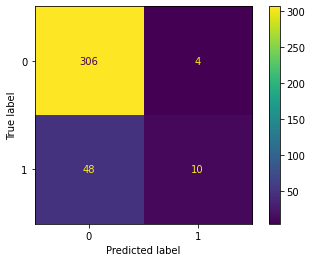

In [48]:
# confusion matrix는 다소 불만족스러우나, roc_auc_score가 높으므로 cutoff 조정 가능
ConfusionMatrixDisplay.from_predictions(y_test, logreg.predict(X_test_sc))

In [49]:
# cutoff를 0.65을 기준으로 → 최대한 accuracy가 유지되는 선에서 Attrition할 것이란 예측을 극대화
y_hat = np.where(logreg.predict_proba(X_test_sc)[:, 0] >= 0.65, 0, 1)
y_hat

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

0.8586956521739131


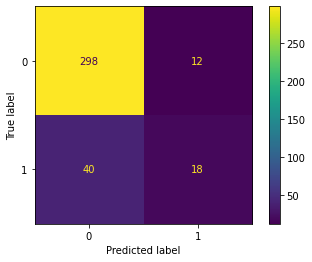

In [50]:
# prediction proba 0.65 기준 confusion matrix와 accuracy score 확인
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
print(accuracy_score(y_test, y_hat))

In [51]:
# 일정 수준 이상의 coef만 출력하여 확인
X_coef = (pd.DataFrame(logreg.coef_.T, index=X_poly.columns, columns=['Coefficient'])
          .query("Coefficient > 0.07 or Coefficient < -0.07")
          .reset_index()
)
X_coef

,index,Coefficient
0,Age JobInvolvement,-0.091454
1,NumCompaniesWorked EnvironmentSatisfaction_1,0.094998
2,WorkLifeBalance YearsWithCurrManager,-0.075827
3,Age JobInvolvement JobSatisfaction,-0.087712
4,DistanceFromHome OverTime PerformanceRating,0.108519
5,NumCompaniesWorked OverTime Gender_Male,0.114950
6,OverTime WorkLifeBalance JobRole_SalesRepresen...,0.100372
7,OverTime YearsSinceLastPromotion MaritalStatus...,0.079037
8,OverTime PerformanceRating MaritalStatus_Single,0.097376
9,OverTime Education_3 JobRole_LaboratoryTechnician,0.123153


In [52]:
coef_col_imsi = np.sort(X_coef['index'].str.split(' ', expand=True).replace({None:'ZZZ'}).values, axis=1)
coef_col_imsi

array([['Age', 'JobInvolvement', 'ZZZ'],
       ['EnvironmentSatisfaction_1', 'NumCompaniesWorked', 'ZZZ'],
       ['WorkLifeBalance', 'YearsWithCurrManager', 'ZZZ'],
       ['Age', 'JobInvolvement', 'JobSatisfaction'],
       ['DistanceFromHome', 'OverTime', 'PerformanceRating'],
       ['Gender_Male', 'NumCompaniesWorked', 'OverTime'],
       ['JobRole_SalesRepresentative', 'OverTime', 'WorkLifeBalance'],
       ['MaritalStatus_Single', 'OverTime', 'YearsSinceLastPromotion'],
       ['MaritalStatus_Single', 'OverTime', 'PerformanceRating'],
       ['Education_3', 'JobRole_LaboratoryTechnician', 'OverTime'],
       ['EducationField_LifeSciences', 'JobRole_LaboratoryTechnician',
        'MaritalStatus_Single']], dtype=object)

In [53]:
# 모델에 영향을 미치는 Feature들을 추출한 후 확인
# negative 영향 : Age-JobInvolvement / HighWLB 등
# positive 영향 : LowEnvSatis-FreqMove / FreqMove-LowWLB / Single-LowWLB 등
X_coef_df = (pd.concat([pd.DataFrame(coef_col_imsi), X_coef.drop('index', axis=1)], axis=1)
             .rename({0:'Feat1', 1:'Feat2', 2:'Feat3'}, axis=1)
             .sort_values(by=['Feat1', 'Feat2', 'Feat3'])
             .replace({'ZZZ':None})
)
X_coef_df

,Feat1,Feat2,Feat3,Coefficient
3,Age,JobInvolvement,JobSatisfaction,-0.087712
0,Age,JobInvolvement,None,-0.091454
4,DistanceFromHome,OverTime,PerformanceRating,0.108519
10,EducationField_LifeSciences,JobRole_LaboratoryTechnician,MaritalStatus_Single,0.075558
9,Education_3,JobRole_LaboratoryTechnician,OverTime,0.123153
1,EnvironmentSatisfaction_1,NumCompaniesWorked,None,0.094998
5,Gender_Male,NumCompaniesWorked,OverTime,0.114950
6,JobRole_SalesRepresentative,OverTime,WorkLifeBalance,0.100372
8,MaritalStatus_Single,OverTime,PerformanceRating,0.097376
7,MaritalStatus_Single,OverTime,YearsSinceLastPromotion,0.079037


In [54]:
# 재직 중인 인원만 모델링의 test set로 삼기 위해 가져오기
attr_no

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single,Attrition
EmpNum,,,,,,,,,,,,,,,,,,,,,
2,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,3068.0,13.0,0.0,32.0,2.0,0.0,8.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,2670.0,20.0,3.0,59.0,3.0,4.0,12.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2062,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2064,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
# 모두 재직 중이므로 Attrition Feature 제외
X_attr_no = attr_no.drop('Attrition', axis=1)
X_attr_no

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Divorced,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single
EmpNum,,,,,,,,,,,,,,,,,,,,,
2,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3068.0,13.0,0.0,32.0,2.0,0.0,8.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2670.0,20.0,3.0,59.0,3.0,4.0,12.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2062,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2064,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# StandardScaler 수행 → 기존 X_train에서 진행되었던걸 그대로 수행해야
X_attr_no_sc = scaler.transform(X_attr_no)
X_attr_no_sc

array([[-0.28600688,  2.14589337,  0.22713711, ...,  0.        ,
         0.        ,  0.        ],
       [-0.75651364, -1.14194047, -0.93707262, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63809253, -0.86795432,  0.22713711, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.07162019,  1.32393491,  0.22713711, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23092729, -0.31998201, -0.93707262, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43980603, -0.86795432, -0.93707262, ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
# 학습된 LogisticRegression을 StandardScale된 X_attr_no_sc에 적용하여 예측
# 재직자를 대상으로 학습된 모델을 적용하면 당연히 Attrition 대상이 적을 수 밖에 없음 → predict_proba를 통해 cutoff를 0.7로 조정
# 학습 모델에서 cutoff=0.7까지는 Attrition 대상자의 accuracy가 용납 가능한 정도
y_hat = np.where(logreg.predict_proba(X_attr_no_sc)[:, 0] >= 0.7, 0, 1)
y_hat.sum()

60

In [57]:
# 재직자 중 Attrition이 예상되는 인원만 추출하여 DataFrame화
X_attr_pred = (X_attr_no
               .reset_index()
               .assign(AttritionPred=y_hat)
               .set_index('EmpNum')
               .query("AttritionPred == 1")
)
X_attr_pred

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single,AttritionPred
EmpNum,,,,,,,,,,,,,,,,,,,,,
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
15,4193.0,12.0,0.0,29.0,15.0,0.0,10.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
24,3944.0,11.0,0.0,38.0,2.0,5.0,6.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
62,5772.0,21.0,0.0,46.0,5.0,4.0,14.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
72,4157.0,19.0,1.0,26.0,23.0,7.0,5.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
120,5441.0,22.0,0.0,51.0,21.0,0.0,11.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
193,4317.0,20.0,0.0,38.0,3.0,3.0,19.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
329,19068.0,18.0,0.0,52.0,2.0,1.0,33.0,5.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
351,2593.0,11.0,1.0,42.0,2.0,0.0,10.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [25]:
# 수많은 Feature들 중 X_coef에서 나온 유의미한 Feature들만 추출
X_attr_pred_part = X_attr_pred[X_coef['index'].to_list()]
X_attr_pred_part

,Age JobInvolvement,NumCompaniesWorked EnvironmentSatisfaction_1,WorkLifeBalance YearsWithCurrManager,Age JobInvolvement JobSatisfaction,DistanceFromHome OverTime PerformanceRating,NumCompaniesWorked OverTime Gender_Male,OverTime WorkLifeBalance JobRole_SalesRepresentative,OverTime YearsSinceLastPromotion MaritalStatus_Single,OverTime PerformanceRating MaritalStatus_Single,OverTime Education_3 JobRole_LaboratoryTechnician,EducationField_LifeSciences JobRole_LaboratoryTechnician MaritalStatus_Single
EmpNum,,,,,,,,,,,
7,81.0,9.0,6.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,58.0,0.0,24.0,174.0,45.0,0.0,0.0,0.0,3.0,0.0,1.0
24,114.0,0.0,6.0,456.0,6.0,5.0,0.0,1.0,3.0,0.0,0.0
62,138.0,4.0,24.0,552.0,20.0,4.0,0.0,0.0,4.0,0.0,0.0
72,52.0,0.0,0.0,208.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0
120,153.0,0.0,0.0,612.0,84.0,0.0,0.0,1.0,4.0,0.0,0.0
193,114.0,0.0,6.0,342.0,12.0,0.0,0.0,2.0,4.0,0.0,0.0
329,104.0,1.0,48.0,312.0,6.0,1.0,0.0,15.0,3.0,0.0,0.0
351,84.0,0.0,24.0,84.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0


In [58]:
# K-Means Clustering을 위한 StandardScaler 진행
# 전체 대비를 파악해야하므로 X_poly가 고려된 scaler를 적용
scaler = StandardScaler().fit(X_poly[X_coef['index'].to_list()])
X_attr_part_sc = scaler.transform(X_attr_pred_part)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\clust

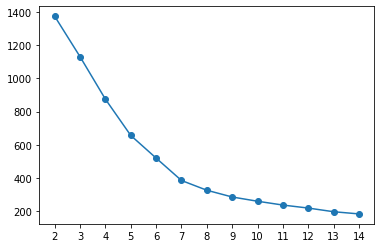

In [59]:
# 적정 cluster 수 파악을 위한 elbow graph 확인
# kmeans를 통해서는 딱 떨어지는 cluster 수를 파악하기 힘듦
inertias = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i).fit(X_attr_part_sc)
    inertias.append(kmeans.inertia_)
plt.plot(inertias, marker='o')
plt.xticks(ticks=range(13), labels=range(2, 15))
plt.show()

In [60]:
# 참고용으로 calinski-harabasz score 확인
# 3개 cluster가 그나마 적절
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_attr_part_sc)
    print(calinski_harabasz_score(X_attr_part_sc, kmeans.labels_))

c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\clust

14.90815221674001
15.029652874338822
17.142572105349142
22.384263660867507
25.120560262194168
30.659830412373832
31.72055687932234
31.988288884957704
31.142062356396846
30.582855982432125
29.2894692412442
29.581464619346622
27.315514718868506


c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


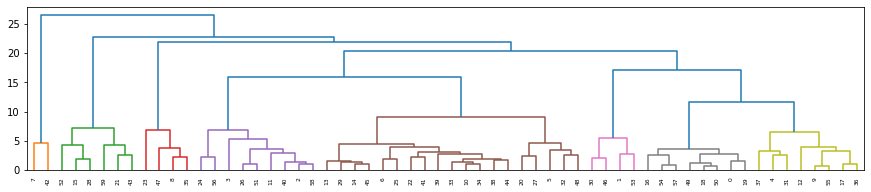

In [61]:
# 혹시 모르니 hierachical clustering도 진행
# ward method로 확인
cluster = sch.linkage(X_attr_part_sc, method='ward', metric='euclidean')
plt.figure(figsize=(15, 3))
sch.dendrogram(cluster, color_threshold=10)
plt.show()

In [63]:
# hierachical clustering을 통한 작업을 적용
assignments = sch.fcluster(cluster, t=10, criterion='distance')
assignments
# 참고 K-Means를 통한 작업
#kmeans = KMeans(n_clusters=7, random_state=0).fit(X_attr_part_sc)
#assignments = kmeans.labels_
#assignments

array([7, 6, 4, 4, 8, 5, 5, 1, 3, 8, 5, 4, 8, 5, 5, 2, 7, 8, 7, 7, 5, 2,
       5, 3, 4, 5, 4, 5, 2, 5, 6, 8, 5, 5, 5, 3, 8, 8, 5, 5, 4, 5, 1, 2,
       5, 5, 6, 3, 5, 7, 7, 4, 2, 6, 7, 8, 4, 7, 4, 2], dtype=int32)

In [64]:
X_attr_cluster = (X_attr_pred_part
                  .reset_index()
                  .assign(cluster=assignments)
                  .set_index('EmpNum')
                  .sort_values(by='cluster', ascending=True)
)
X_attr_cluster

,Age JobInvolvement,NumCompaniesWorked EnvironmentSatisfaction_1,WorkLifeBalance YearsWithCurrManager,Age JobInvolvement JobSatisfaction,DistanceFromHome OverTime PerformanceRating,NumCompaniesWorked OverTime Gender_Male,OverTime WorkLifeBalance JobRole_SalesRepresentative,OverTime YearsSinceLastPromotion MaritalStatus_Single,OverTime PerformanceRating MaritalStatus_Single,OverTime Education_3 JobRole_LaboratoryTechnician,EducationField_LifeSciences JobRole_LaboratoryTechnician MaritalStatus_Single,cluster
EmpNum,,,,,,,,,,,,
1539,50.0,0.0,27.0,200.0,66.0,1.0,0.0,13.0,3.0,0.0,0.0,1
329,104.0,1.0,48.0,312.0,6.0,1.0,0.0,15.0,3.0,0.0,0.0,1
925,94.0,0.0,4.0,376.0,6.0,0.0,2.0,1.0,3.0,0.0,0.0,2
666,102.0,0.0,18.0,306.0,42.0,0.0,3.0,0.0,0.0,0.0,0.0,2
1055,102.0,0.0,0.0,306.0,30.0,0.0,3.0,0.0,0.0,0.0,0.0,2
1556,108.0,0.0,4.0,432.0,8.0,3.0,2.0,1.0,4.0,0.0,0.0,2
2021,63.0,0.0,6.0,63.0,15.0,1.0,3.0,1.0,3.0,0.0,0.0,2
1835,38.0,0.0,6.0,152.0,8.0,0.0,2.0,0.0,0.0,0.0,0.0,2
351,84.0,0.0,24.0,84.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,3


In [65]:
# 좀 더 손쉬운 파악을 위한 Factor analysis 진행
cumul_var_list = []
for i in range(3, 10):
    fa = FactorAnalyzer(n_factors=i, method='principal', rotation='varimax').fit(X_attr_part_sc)
    cumul_var_list.append(fa.get_factor_variance()[2][i-1])
np.array(cumul_var_list)

array([0.5030091 , 0.6059585 , 0.70314219, 0.79283832, 0.86683951,
       0.91939698, 0.95784009])

In [70]:
# Variance 설명량이 70% 이상인 n_factors를 선택하여 Factor Loadings 확인
n_factors = 5
fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax').fit(X_attr_part_sc)
fl_matrix = pd.DataFrame(fa.loadings_, columns=[f'Factor{i:02}' for i in range(1, n_factors + 1)], index=X_attr_pred_part.columns)
fl_matrix

,Factor01,Factor02,Factor03,Factor04,Factor05
Age JobInvolvement,-0.154342,0.855178,0.032909,0.112179,0.003845
NumCompaniesWorked EnvironmentSatisfaction_1,-0.905998,0.189335,-0.035787,-0.129243,-0.112465
WorkLifeBalance YearsWithCurrManager,0.122974,-0.055820,0.816776,0.320508,-0.089766
Age JobInvolvement JobSatisfaction,0.153756,0.786171,-0.019454,-0.311717,0.053746
DistanceFromHome OverTime PerformanceRating,0.391865,0.066746,0.307974,0.021715,0.295620
NumCompaniesWorked OverTime Gender_Male,0.470966,0.531409,-0.209828,0.044754,-0.242663
OverTime WorkLifeBalance JobRole_SalesRepresentative,0.118157,-0.145426,-0.133030,-0.138746,0.816271
OverTime YearsSinceLastPromotion MaritalStatus_Single,0.075110,-0.014952,0.861492,-0.129298,0.004217
OverTime PerformanceRating MaritalStatus_Single,0.651525,0.237993,0.363408,-0.275556,-0.085985
OverTime Education_3 JobRole_LaboratoryTechnician,0.031156,-0.037851,0.064541,0.933876,-0.024727


In [71]:
# 각 Columns가 어떤 Factor에 속하는지, 그 Factor에서의 Factor Loadings는 어떻게 되는지 확인
fl_df = (pd.concat([fl_matrix.idxmax(axis=1), fl_matrix.max(axis=1)], axis=1)
         .rename({0:'Idxmax', 1:'Max'}, axis=1)
         .sort_values(by='Idxmax', ascending=True)
)
fl_df

,Idxmax,Max
DistanceFromHome OverTime PerformanceRating,Factor01,0.391865
OverTime PerformanceRating MaritalStatus_Single,Factor01,0.651525
EducationField_LifeSciences JobRole_LaboratoryTechnician MaritalStatus_Single,Factor01,0.104974
Age JobInvolvement,Factor02,0.855178
NumCompaniesWorked EnvironmentSatisfaction_1,Factor02,0.189335
Age JobInvolvement JobSatisfaction,Factor02,0.786171
NumCompaniesWorked OverTime Gender_Male,Factor02,0.531409
WorkLifeBalance YearsWithCurrManager,Factor03,0.816776
OverTime YearsSinceLastPromotion MaritalStatus_Single,Factor03,0.861492
OverTime Education_3 JobRole_LaboratoryTechnician,Factor04,0.933876


In [72]:
# Factor들에 대한 해석
factor_interpret = {'Factor01':'OverTime_Performance', 'Factor02':'Age_JobInvolvement', 'Factor03':'PromotionPeriod',
                    'Factor04':'OverTime_Technician', 'Factor05':'OverTime_Sales'}

In [73]:
X_attr_fa = pd.DataFrame(fa.transform(X_attr_part_sc), columns=factor_interpret.values(), index=X_attr_pred_part.index)
X_attr_fa

,OverTime_Performance,Age_JobInvolvement,HighWLB_etc,OverTime_Technician,OverTime_Sales
EmpNum,,,,,
7,-2.464129,-0.154684,-0.013609,-0.307742,-0.243672
15,1.132914,-1.774448,0.556098,-0.795125,-1.808945
24,0.883222,1.373970,-0.389541,-0.311448,-0.583833
62,0.036768,2.174299,0.725538,-0.344371,-0.551079
72,0.326458,-0.909736,-0.406439,-0.044824,0.747264
120,0.881575,1.976597,0.424268,-0.786877,0.854170
193,0.372958,0.544715,0.426061,-0.583833,-0.081483
329,-0.572911,0.324608,4.918683,-0.615886,-0.396019
351,-0.169628,-0.727678,0.149555,3.641424,-0.164854


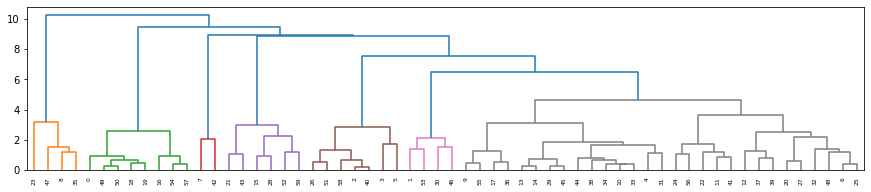

In [74]:
# Factor analysis 완료된 자료로 다시 hierachical clustering도 진행
# ward method로 확인
cluster = sch.linkage(X_attr_fa, method='ward', metric='euclidean')
plt.figure(figsize=(15, 3))
sch.dendrogram(cluster, color_threshold=6)
plt.show()

c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\clust

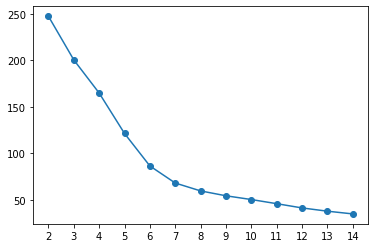

In [75]:
# kmeans로도 확인
inertias = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i).fit(X_attr_fa)
    inertias.append(kmeans.inertia_)
plt.plot(inertias, marker='o')
plt.xticks(ticks=range(13), labels=range(2, 15))
plt.show()

In [77]:
# kmeans를 통한 작업을 적용
assignments = KMeans(n_clusters=7).fit_predict(X_attr_fa)
assignments
# 참고 K-Means를 통한 작업
#kmeans = KMeans(n_clusters=7, random_state=0).fit(X_attr_fa)
#assignments = kmeans.labels_
#assignments

c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([3, 0, 2, 2, 1, 2, 2, 5, 4, 1, 1, 2, 2, 1, 1, 6, 3, 1, 3, 3, 1, 6,
       1, 4, 2, 2, 2, 1, 6, 1, 0, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 2, 5, 2,
       1, 1, 0, 4, 2, 3, 3, 2, 6, 0, 3, 3, 2, 3, 2, 6])

In [78]:
# 최종 cluster 확인 → Factor analysis로 인해 내용 파악 용이
X_attr_fa_cluster = (X_attr_fa
                     .reset_index()
                     .assign(cluster=assignments)
                     .set_index('EmpNum')
                     .sort_values(by='cluster', ascending=True)
)
X_attr_fa_cluster

,OverTime_Performance,Age_JobInvolvement,HighWLB_etc,OverTime_Technician,OverTime_Sales,cluster
EmpNum,,,,,,
15,1.132914,-1.774448,0.556098,-0.795125,-1.808945,0
1198,0.045117,-2.312010,-0.862382,-0.849009,-2.032644,0
1659,-0.496041,-0.954060,-0.484865,-0.668768,-2.008751,0
1850,0.889112,-1.006476,-0.483510,-1.297781,-1.949949,0
1131,0.355664,-1.340114,0.262668,-0.354936,-0.258935,1
904,0.420390,0.305542,1.063468,0.253059,0.164696,1
1043,0.456368,-0.065718,1.461118,0.247876,0.396138,1
1244,-0.194549,-0.700000,0.153579,0.514975,0.200827,1
1269,0.910802,-0.122656,0.083340,-0.419582,0.643838,1


In [79]:
# 내용 확인
# cluster 0 : Age, JobInvolvement, WLB 등에 문제가 생긴 케이스
# cluster 1 : 세부 조사가 필요한 다양한 이유(단, 기존 재직 회사가 많지 않은 편)
# cluster 2 : Age, JobInvolvement가 강함에도 다양한 문제가 생긴 케이스
# cluster 3 : Performance가 떨어지는 케이스
# cluster 4 : Technician 쪽에서 OverTime이 잦은 케이스
# cluster 5 : 최근 승진이 오래된 케이스
# cluster 6 : Sales 쪽에서 이직이 잦았으며, 워라밸이 안좋은 케이스
hr_df_attr_cluster_1 = (hr_df.loc[X_attr_fa_cluster.index, :]
                        .assign(Cluster=X_attr_fa_cluster['cluster'])
)
hr_df_attr_cluster_1

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,Gender,MaritalStatus,Education,EducationField,DistanceFromHome,NumCompaniesWorked,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,Attrition,Cluster
EmpNum,,,,,,,,,,,,,,,,,,,,,
15,4193,12,0,29,Female,Single,2,LifeSciences,15,0,...,9,5,0,8,4,3,3,4,0,0
1198,3033,12,0,20,Male,Single,3,LifeSciences,3,1,...,2,2,1,2,1,3,3,1,0,0
1659,2013,11,0,36,Male,Single,3,LifeSciences,7,2,...,4,3,1,3,1,2,3,3,0,0
1850,2379,14,0,27,Female,Single,2,LifeSciences,5,0,...,5,4,0,2,4,4,3,3,0,0
1131,2070,11,0,21,Female,Single,1,TechnicalDegree,1,1,...,2,2,2,2,4,2,3,3,0,1
904,7642,13,0,37,Male,Single,2,Medical,19,1,...,10,0,0,9,1,2,3,4,0,1
1043,10880,13,0,39,Female,Single,3,Medical,22,1,...,21,6,2,8,4,1,3,3,0,1
1244,2235,14,2,27,Male,Married,3,LifeSciences,14,1,...,9,7,6,8,1,1,3,4,0,1
1269,2994,12,0,19,Female,Single,3,LifeSciences,25,1,...,1,0,0,1,2,4,3,4,0,1


In [41]:
# 기타 사항
# original data(one-hot data)로 다시 clustering 진행 가능
# cluster 후 one-hot data 바탕으로 Factor analysis 진행 및 내용 확인 가능
# 실제 Data에서는 좀 더 정교하게 경향성 확인 가능

In [81]:
hr_df_attr_cluster_1.query("Cluster == 1").T

EmpNum,1131,904,1043,1244,1269,1286,1301,1390,1402,1425,1611,1281,783,939,1586,527,72,493,424,437
MonthlyIncome,2070,7642,10880,2235,2994,2154,2080,6120,4081,9278,5769,4538,6632,2799,4723,4487,4157,2657,6410,4478
PercentSalaryHike,11,13,13,14,12,11,11,12,14,16,14,12,13,11,18,11,19,16,12,11
StockOptionLevel,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0
Age,21,37,39,27,19,28,28,39,43,36,45,34,45,33,29,25,26,31,31,27
Gender,Female,Male,Female,Male,Female,Male,Male,Male,Female,Female,Female,Female,Male,Male,Male,Female,Female,Male,Male,Male
MaritalStatus,Single,Single,Single,Married,Single,Single,Single,Married,Single,Single,Single,Single,Single,Single,Single,Single,Married,Single,Married,Single
Education,1,2,3,3,3,4,3,4,3,4,5,3,2,4,1,2,3,4,3,3
EducationField,TechnicalDegree,Medical,Medical,LifeSciences,LifeSciences,Medical,TechnicalDegree,LifeSciences,Medical,Marketing,Medical,Marketing,TechnicalDegree,Other,Medical,LifeSciences,Marketing,LifeSciences,HumanResources,LifeSciences
DistanceFromHome,1,19,22,14,25,1,1,21,6,3,5,2,2,1,3,4,23,9,2,2
NumCompaniesWorked,1,1,1,1,1,0,2,3,1,3,1,0,0,3,1,1,7,0,3,1
